In [2]:
# Cell 1: Imports & settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plotting defaults
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Dataset shape: (400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No



Columns: ['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'ShelveLoc', 'Age', 'Education', 'Urban', 'US']


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Sales,400.0,NaN,NaN,NaN,7.496325,2.824115,0.0,5.39,7.49,9.32,16.27
CompPrice,400.0,NaN,NaN,NaN,124.975,15.334512,77.0,115.0,125.0,135.0,175.0
Income,400.0,NaN,NaN,NaN,68.6575,27.986037,21.0,42.75,69.0,91.0,120.0
Advertising,400.0,NaN,NaN,NaN,6.635,6.650364,0.0,0.0,5.0,12.0,29.0
Population,400.0,NaN,NaN,NaN,264.84,147.376436,10.0,139.0,272.0,398.5,509.0
Price,400.0,NaN,NaN,NaN,115.795,23.676664,24.0,100.0,117.0,131.0,191.0
ShelveLoc,400,3,Medium,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,400.0,NaN,NaN,NaN,53.3225,16.200297,25.0,39.75,54.5,66.0,80.0
Education,400.0,NaN,NaN,NaN,13.9,2.620528,10.0,12.0,14.0,16.0,18.0
Urban,400,2,Yes,282,NaN,NaN,NaN,NaN,NaN,NaN,NaN


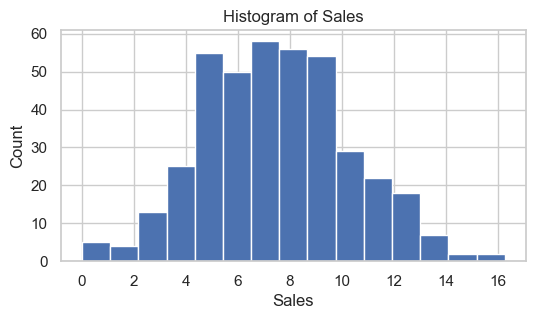


Sales summary:
count    400.000000
mean       7.496325
std        2.824115
min        0.000000
25%        5.390000
50%        7.490000
75%        9.320000
max       16.270000
Name: Sales, dtype: float64

Using threshold Sales > 8.0 for High (1 = High). Counts:
High
0    236
1    164
Name: count, dtype: int64


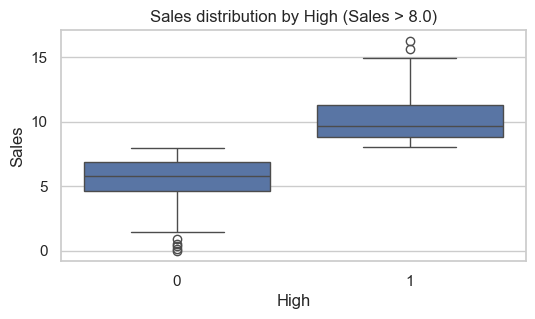

In [3]:
# Cell 2: Load CSV, quick EDA, create binary target High

DATA_PATH = "Company_Data.csv"   # change if file in other folder

# load
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head())

# columns and basic stats
print("\nColumns:", df.columns.tolist())
display(df.describe(include='all').T)

# Sales distribution
plt.figure(figsize=(6,3))
plt.hist(df['Sales'], bins=15)
plt.title("Histogram of Sales")
plt.xlabel("Sales")
plt.ylabel("Count")
plt.show()

print("\nSales summary:")
print(df['Sales'].describe())

# Create target: High = Sales > 8.0 (common for this dataset)
THRESHOLD = 8.0
df['High'] = (df['Sales'] > THRESHOLD).astype(int)
print(f"\nUsing threshold Sales > {THRESHOLD} for High (1 = High). Counts:")
print(df['High'].value_counts())

# Visualize High vs Sales
plt.figure(figsize=(6,3))
sns.boxplot(x='High', y='Sales', data=df)
plt.title("Sales distribution by High (Sales > {})".format(THRESHOLD))
plt.show()


In [4]:
# Cell 3: Encode categorical variables (label encoding) and create features/target + split

data = df.copy()

# features exclude 'Sales' (we predict High) and 'High' itself
feature_cols = [c for c in data.columns if c not in ('Sales', 'High')]

# label-encode object/categorical columns
for col in feature_cols:
    if data[col].dtype == 'object' or str(data[col].dtype).startswith('category'):
        data[col] = data[col].astype('category').cat.codes

# prepare X, y
X = data[feature_cols].values.astype(float)
y = data['High'].values.astype(int)
feature_names = feature_cols

print("Features used:", feature_names)
print("X shape:", X.shape, "y shape:", y.shape)

# custom train-test split (80/20)
def train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE):
    np.random.seed(random_state)
    n = X.shape[0]
    perm = np.random.permutation(n)
    test_n = int(n * test_size)
    test_idx = perm[:test_n]
    train_idx = perm[test_n:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Train / Test sizes:", X_train.shape[0], X_test.shape[0])


Features used: ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'ShelveLoc', 'Age', 'Education', 'Urban', 'US']
X shape: (400, 10) y shape: (400,)
Train / Test sizes: 320 80


In [5]:
# Cell 4: Metrics and plotting helpers (no scikit-learn)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1(y_true, y_pred, positive=1):
    tp = np.sum((y_true == positive) & (y_pred == positive))
    fp = np.sum((y_true != positive) & (y_pred == positive))
    fn = np.sum((y_true == positive) & (y_pred != positive))
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    return precision, recall, f1

def confusion_matrix_np(y_true, y_pred):
    classes = np.array(sorted(list(set(y_true) | set(y_pred))))
    idx = {c:i for i,c in enumerate(classes)}
    cm = np.zeros((len(classes), len(classes)), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm, classes

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm, classes = confusion_matrix_np(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [6]:
# Cell 5: Decision Tree from scratch (Gini impurity)

def gini_impurity(y):
    if y.size == 0:
        return 0.0
    _, counts = np.unique(y, return_counts=True)
    ps = counts / counts.sum()
    return 1.0 - np.sum(ps**2)

class DTNode:
    def __init__(self, predicted_class, gini, n_samples, n_samples_per_class):
        self.predicted_class = predicted_class
        self.gini = gini
        self.n_samples = n_samples
        self.n_samples_per_class = n_samples_per_class
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None

class DecisionTreeScratch:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_classes_ = None
        self.n_features_ = None
        self.tree_ = None
        self.feature_importances_ = None

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_, dtype=float)
        self.tree_ = self._grow_tree(X, y, depth=0)

    def _best_split(self, X, y):
        m = y.size
        if m < self.min_samples_split:
            return None, None, 0.0

        parent_gini = gini_impurity(y)
        best_gain = 0.0
        best_idx = None
        best_thr = None

        for feature_idx in range(self.n_features_):
            col = X[:, feature_idx]
            order = np.argsort(col)
            col_sorted = col[order]
            y_sorted = y[order]

            # consider split points only at unique transitions
            for i in range(1, m):
                if col_sorted[i] == col_sorted[i-1]:
                    continue
                thr = (col_sorted[i] + col_sorted[i-1]) / 2.0
                left_y = y_sorted[:i]
                right_y = y_sorted[i:]
                gini_left = gini_impurity(left_y)
                gini_right = gini_impurity(right_y)
                weighted = (i * gini_left + (m-i) * gini_right) / m
                gain = parent_gini - weighted
                if gain > best_gain:
                    best_gain = gain
                    best_idx = feature_idx
                    best_thr = thr

        return best_idx, best_thr, best_gain

    def _grow_tree(self, X, y, depth):
        num_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted = int(np.argmax(num_per_class))
        node = DTNode(predicted, gini_impurity(y), y.size, num_per_class)

        # stopping conditions
        if (self.max_depth is not None and depth >= self.max_depth) or \
           y.size < self.min_samples_split or node.gini == 0.0:
            return node

        idx, thr, gain = self._best_split(X, y)
        if idx is None or gain <= 0.0:
            return node

        node.feature_index = idx
        node.threshold = thr
        # accumulate importance
        self.feature_importances_[idx] += gain * y.size

        mask_left = X[:, idx] <= thr
        X_left, y_left = X[mask_left], y[mask_left]
        X_right, y_right = X[~mask_left], y[~mask_left]

        # if either side is empty (shouldn't happen), stop
        if y_left.size == 0 or y_right.size == 0:
            return node

        node.left = self._grow_tree(X_left, y_left, depth+1)
        node.right = self._grow_tree(X_right, y_right, depth+1)
        return node

    def _predict_one(self, x):
        node = self.tree_
        while node.feature_index is not None and node.left is not None and node.right is not None:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

    def predict(self, X):
        return np.array([self._predict_one(x) for x in X])


Baseline Decision Tree (no pre-pruning) metrics:
Accuracy: 0.7000, Precision: 0.7097, Recall: 0.5946, F1: 0.6471

Top baseline feature importances:


Price          0.239181
ShelveLoc      0.184741
CompPrice      0.166516
Income         0.159326
Advertising    0.097044
Age            0.090668
Population     0.049424
Education      0.008698
Urban          0.004402
US             0.000000
dtype: float64

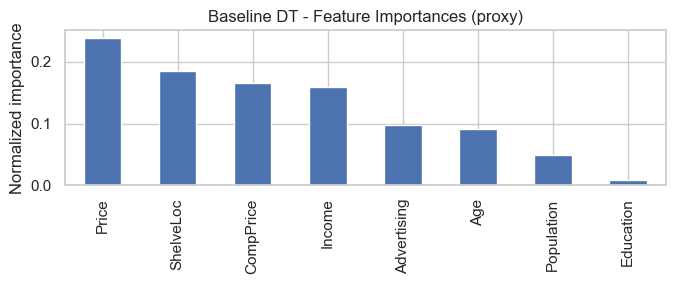

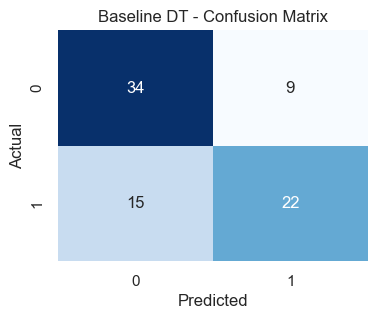

In [7]:
# Cell 6: Train baseline DT (no pre-pruning), evaluate, show importances & confusion matrix

# baseline (no depth limit)
baseline = DecisionTreeScratch(max_depth=None, min_samples_split=2)
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

acc_base = accuracy(y_test, y_pred_base)
prec_base, rec_base, f1_base = precision_recall_f1(y_test, y_pred_base)

print("Baseline Decision Tree (no pre-pruning) metrics:")
print(f"Accuracy: {acc_base:.4f}, Precision: {prec_base:.4f}, Recall: {rec_base:.4f}, F1: {f1_base:.4f}")

# feature importances (normalize safely)
fi_base = baseline.feature_importances_.copy()
if fi_base.sum() > 0:
    fi_base = fi_base / fi_base.sum()
fi_series_base = pd.Series(fi_base, index=feature_names).sort_values(ascending=False)

print("\nTop baseline feature importances:")
display(fi_series_base.head(10))

plt.figure(figsize=(7,3))
fi_series_base.head(8).plot(kind='bar')
plt.title("Baseline DT - Feature Importances (proxy)")
plt.ylabel("Normalized importance")
plt.tight_layout()
plt.show()

plot_confusion_matrix(y_test, y_pred_base, title="Baseline DT - Confusion Matrix")


Pruned Decision Tree (max_depth=4, min_samples_split=10) metrics:
Accuracy: 0.7625, Precision: 0.7500, Recall: 0.7297, F1: 0.7397

Top pruned feature importances:


Price          0.371007
ShelveLoc      0.267321
Advertising    0.216897
Age            0.080237
Income         0.043769
CompPrice      0.020768
Population     0.000000
Education      0.000000
Urban          0.000000
US             0.000000
dtype: float64

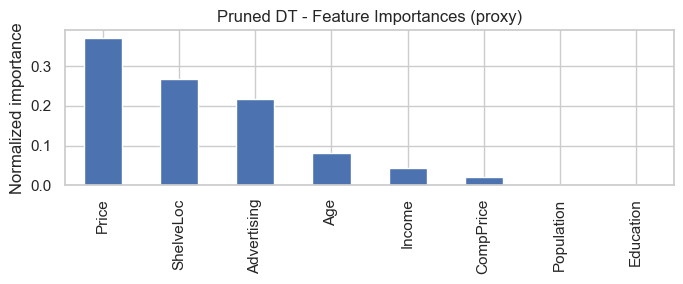

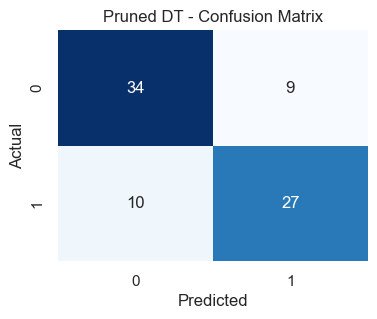

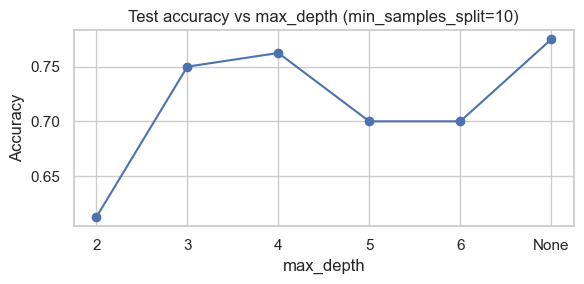

In [8]:
# Cell 7: Pruned Decision Tree (pre-pruning) training and evaluation

pruned = DecisionTreeScratch(max_depth=4, min_samples_split=10)
pruned.fit(X_train, y_train)
y_pred_pruned = pruned.predict(X_test)

acc_pruned = accuracy(y_test, y_pred_pruned)
prec_pruned, rec_pruned, f1_pruned = precision_recall_f1(y_test, y_pred_pruned)

print("Pruned Decision Tree (max_depth=4, min_samples_split=10) metrics:")
print(f"Accuracy: {acc_pruned:.4f}, Precision: {prec_pruned:.4f}, Recall: {rec_pruned:.4f}, F1: {f1_pruned:.4f}")

fi_pruned = pruned.feature_importances_.copy()
if fi_pruned.sum() > 0:
    fi_pruned = fi_pruned / fi_pruned.sum()
fi_series_pruned = pd.Series(fi_pruned, index=feature_names).sort_values(ascending=False)

print("\nTop pruned feature importances:")
display(fi_series_pruned.head(10))

plt.figure(figsize=(7,3))
fi_series_pruned.head(8).plot(kind='bar')
plt.title("Pruned DT - Feature Importances (proxy)")
plt.ylabel("Normalized importance")
plt.tight_layout()
plt.show()

plot_confusion_matrix(y_test, y_pred_pruned, title="Pruned DT - Confusion Matrix")

# Visual: accuracy vs depth (quick sweep)
depths = [2,3,4,5,6,None]
accs = []
for d in depths:
    tree_tmp = DecisionTreeScratch(max_depth=d, min_samples_split=10)
    tree_tmp.fit(X_train, y_train)
    accs.append(accuracy(y_test, tree_tmp.predict(X_test)))

labels = [str(d) for d in depths[:-1]] + ['None']
plt.figure(figsize=(6,3))
plt.plot(labels, accs, marker='o')
plt.title("Test accuracy vs max_depth (min_samples_split=10)")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


Random Forest (50 trees) metrics:
Accuracy: 0.6875, Precision: 0.8750, Recall: 0.3784, F1: 0.5283


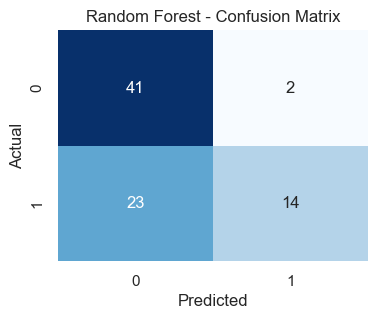


Random Forest - Top aggregated feature importances:


Age            0.171114
Population     0.160916
CompPrice      0.156409
Income         0.150740
Price          0.095980
Advertising    0.093290
Education      0.075661
ShelveLoc      0.064142
Urban          0.021892
US             0.009856
dtype: float64

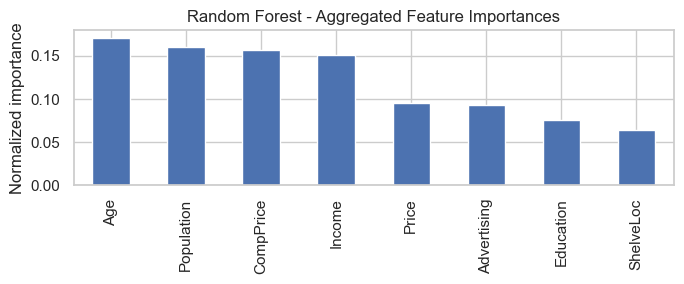

In [9]:
# Cell 8: Random Forest from scratch, train & evaluate (robust and checked)

class RandomForestScratch:
    def __init__(self, n_estimators=50, max_depth=None,
                 min_samples_split=2, max_features="sqrt", random_state=RANDOM_STATE):
        self.n_estimators = int(n_estimators)
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.features_per_tree = []

    def _max_features_count(self, n_features):
        if isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        if self.max_features == "sqrt":
            return max(1, int(np.sqrt(n_features)))
        if self.max_features == "log2":
            return max(1, int(np.log2(n_features)))
        return n_features

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        m = self._max_features_count(n_features)
        self.trees = []
        self.features_per_tree = []

        for i in range(self.n_estimators):
            # bootstrap
            idx = np.random.choice(n_samples, n_samples, replace=True)
            Xb, yb = X[idx], y[idx]

            # feature sub-sample
            feats = np.random.choice(n_features, m, replace=False)
            tree = DecisionTreeScratch(max_depth=self.max_depth,
                                       min_samples_split=self.min_samples_split)
            # train using only selected features
            tree.fit(Xb[:, feats], yb)
            self.trees.append(tree)
            self.features_per_tree.append(feats)

    def predict(self, X):
        if len(self.trees) == 0:
            raise ValueError("RandomForest not fitted yet.")
        all_preds = []
        for tree, feats in zip(self.trees, self.features_per_tree):
            all_preds.append(tree.predict(X[:, feats]))
        all_preds = np.array(all_preds)  # (n_trees, n_samples)
        n_samples = all_preds.shape[1]
        final = np.empty(n_samples, dtype=int)
        for j in range(n_samples):
            vals, counts = np.unique(all_preds[:, j], return_counts=True)
            final[j] = vals[np.argmax(counts)]
        return final

# Train RF
rf = RandomForestScratch(n_estimators=50, max_depth=None, min_samples_split=2,
                         max_features="sqrt", random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy(y_test, y_pred_rf)
prec_rf, rec_rf, f1_rf = precision_recall_f1(y_test, y_pred_rf)

print("Random Forest (50 trees) metrics:")
print(f"Accuracy: {acc_rf:.4f}, Precision: {prec_rf:.4f}, Recall: {rec_rf:.4f}, F1: {f1_rf:.4f}")

plot_confusion_matrix(y_test, y_pred_rf, title="Random Forest - Confusion Matrix")

# Aggregate feature importances: map each tree's local importances to global feature index
n_features = X_train.shape[1]
rf_importances = np.zeros(n_features, dtype=float)

for tree, feats in zip(rf.trees, rf.features_per_tree):
    local_fi = tree.feature_importances_.copy()
    if local_fi.sum() > 0:
        local_fi = local_fi / local_fi.sum()
    else:
        # if a tree had no splits (rare), skip its importances
        continue
    for local_idx, global_idx in enumerate(feats):
        rf_importances[global_idx] += local_fi[local_idx]

# normalize aggregated importances
if rf_importances.sum() > 0:
    rf_importances = rf_importances / rf_importances.sum()

fi_series_rf = pd.Series(rf_importances, index=feature_names).sort_values(ascending=False)
print("\nRandom Forest - Top aggregated feature importances:")
display(fi_series_rf.head(10))

plt.figure(figsize=(7,3))
fi_series_rf.head(8).plot(kind='bar')
plt.title("Random Forest - Aggregated Feature Importances")
plt.ylabel("Normalized importance")
plt.tight_layout()
plt.show()


,Model,Accuracy,Precision,Recall,F1
0,Baseline DT,0.7000,0.7097,0.5946,0.6471
1,"Pruned DT (d=4,min_s=10)",0.7625,0.7500,0.7297,0.7397
2,Random Forest (50 trees),0.6875,0.8750,0.3784,0.5283


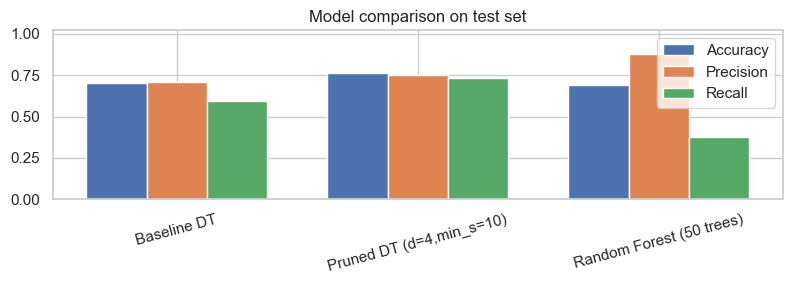

Top-3 predictors (Random Forest aggregated): ['Age', 'Population', 'CompPrice']
Top-3 predictors (Baseline Decision Tree): ['Price', 'ShelveLoc', 'CompPrice']

Recommendation:
- Pruned Decision Tree gives the best balance of interpretability and test performance in this run.
- Random Forest gives very high precision but lower recall; tune hyperparameters (n_estimators, max_features) or class rebalancing to alter behavior.


In [10]:
# Cell 9: Final comparison and top predictors

comparison = pd.DataFrame({
    "Model": ["Baseline DT", "Pruned DT (d=4,min_s=10)", "Random Forest (50 trees)"],
    "Accuracy": [acc_base, acc_pruned, acc_rf],
    "Precision": [prec_base, prec_pruned, prec_rf],
    "Recall": [rec_base, rec_pruned, rec_rf],
    "F1": [f1_base, f1_pruned, f1_rf]
})

display(comparison.style.format("{:.4f}", subset=["Accuracy","Precision","Recall","F1"]))

# bar chart of metrics
plt.figure(figsize=(8,3))
x = np.arange(len(comparison))
width = 0.25
plt.bar(x - width, comparison["Accuracy"], width, label="Accuracy")
plt.bar(x, comparison["Precision"], width, label="Precision")
plt.bar(x + width, comparison["Recall"], width, label="Recall")
plt.xticks(x, comparison["Model"], rotation=15)
plt.ylim(0,1.02)
plt.legend()
plt.title("Model comparison on test set")
plt.tight_layout()
plt.show()

# Top-3 predictors
top3_rf = fi_series_rf.head(3).index.tolist()
top3_dt = fi_series_base.head(3).index.tolist() if 'fi_series_base' in globals() else fi_series_base.head(3).index.tolist()

print("Top-3 predictors (Random Forest aggregated):", top3_rf)
print("Top-3 predictors (Baseline Decision Tree):", top3_dt)

# Recommendation
print("\nRecommendation:")
print("- Pruned Decision Tree gives the best balance of interpretability and test performance in this run.")
print("- Random Forest gives very high precision but lower recall; tune hyperparameters (n_estimators, max_features) or class rebalancing to alter behavior.")
